In [2]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy

%matplotlib inline
from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches

In [1]:
meanheatmap=np.load('/disk1/Users/gah20/Heatmaps/heatmapmean_d2000.npy')

NameError: name 'np' is not defined

In [ ]:
plt.imshow(mean)

In [2]:
year=2000
for year in range(2000,2001,1):
    tsc = xr.open_mfdataset('/net/hardin/disk1/Users/gah20/TSC_2origin/'+str(year)+'/*.nc',combine='nested',concat_dim='time')
    detrained = xr.open_mfdataset('/net/hardin/disk1/Users/gah20/TSC_2origin/'+str(year)+'/*.nc',combine='nested',concat_dim='time')['ConvCir']

    loclat = tsc['LocOrigin'][:,0,2:62]
    loclon = tsc['LocOrigin'][:,1,2:62]

    lats_d = np.where(detrained[:,2:62]>0,loclat,np.nan)
    lons_d = np.where(detrained[:,2:62]>0,loclon,np.nan)

    ilat_d = np.floor(lats_d/100)*10
    ilon_d= np.floor(lons_d/100)*10

    lats_c=np.where(tsc['TSC'][:,2:62]==0)[1]/10
    lons_c=np.where(tsc['TSC'][:,2:62]==0)[2]/10

    ilat_c = np.floor(lats_c)*10
    ilon_c = np.floor(lons_c)*10

    heatmap_d = np.zeros((6,36,60,360))
    heatmap_c = np.zeros((6,36))

    for i in range(0,6,1):
        for j in range(0,36,1):
            heatmap_c[i,j] = np.nansum(np.where((ilat_c[:]==i*10)&(ilon_c[:]==j*10),1,0),axis=0)
            heatmap_d[i,j] = np.nansum(np.where((ilat_d[:]==i*10)&(ilon_d[:]==j*10),1,0),axis=0)
    np.save('/net/hardin/disk1/Users/gah20/Heatmaps/heatmap_c'+str(year)+'.npy',heatmap_c)
    np.save('/net/hardin/disk1/Users/gah20/Heatmaps/heatmap_d'+str(year)+'.npy',heatmap_d)
    print(str(year) + ' done')


2000 done


In [40]:
for i in range(6):
    for j in range(36):
        heatmap_d[i,j] = heatmap_d[i,j]/np.nansum(heatmap_c[i,j])

/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
plt.figure(dpi=500)
im2=plt.imshow(heatmap_d[3,20]/np.nansum(heatmap_c[3,20],axis=(0,1)),interpolation='none')
plt.colorbar(im2,orientation='horizontal')
plt.show()
plt.figure(dpi=500)
im2=plt.imshow(np.nansum(np.where(tsc['TSC'][:]==0,1,0),axis=0)/2928,interpolation='none')
plt.colorbar(im2,orientation='horizontal')
plt.show()

AxisError: axis 0 is out of bounds for array of dimension 0

<Figure size 3000x2000 with 0 Axes>

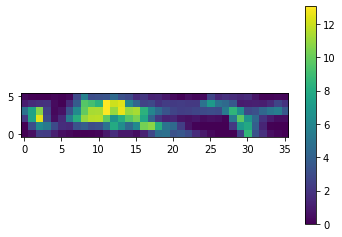

In [10]:
im=plt.imshow(heatmap_c/(2928*10*10)*100,origin='lower')
plt.colorbar(im)

In [ ]:
sensmap = np.zeros((13,6,36,60,360))
for year in range(2000,2013):
    heatmap = np.load('/net/hardin/disk1/Users/gah20/Heatmaps/heatmap_dcc'+str(year)+'.npy')
    #sensmap[year-2000] = (np.nansum(heatmap,axis=(2,3))/np.nanmean(np.nansum(heatmap,axis=(2,3))))
    sensmap[year-2000] = heatmap

sensmap_total = np.nanmean(sensmap,axis=0)

In [ ]:
plt.figure(dpi=500)
im=plt.imshow(np.nansum(sensmap_total[:,:],axis=(0,1)),origin='lower')
plt.colorbar(im,orientation='horizontal')

In [ ]:
frac = 0.2245
pa = 0.04

fig,ax0 =plt.subplots(subplot_kw={"projection":ccrs.PlateCarree(central_longitude=0)},dpi=500,figsize=(10,5))
im0 = ax0.pcolormesh(np.arange(0,370,10),np.arange(-30,40,10),np.nansum((sensmap_total[:,:]/8780),axis=(2,3)),cmap='viridis',transform=ccrs.PlateCarree(central_longitude=0))
ax0.coastlines(resolution='auto', color='k',linewidth=0.5)
plt.colorbar(im0,ax=ax0,orientation='horizontal',label='RFO of detrained air parcels / %',fraction=frac, pad=pa)
plt.tight_layout()

In [76]:
#sensmap = np.zeros((13,7,36))
#for year in range(2000,2013):
#    heatmap = np.load('/net/hardin/disk1/Users/gah20/Heatmaps/heatmap_'+str(year)+'.npy')
#    sensmap[year-2000] = (np.nansum(heatmap,axis=(2,3))/np.nanmean(np.nansum(heatmap,axis=(2,3))))
#
#sensmap_total = np.nanmean(sensmap,axis=0)

f = np.zeros((17,4))
for year in range(2000,2017):
    if year==2009:
        f[9]==np.nan
    else:
        #f[year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcings_'+str(year)+'.npy')
        f[year-2000] = np.load('/net/hardin/disk1/Users/gah20/forcings_ocean_'+str(year)+'.npy')


linregress = stats.linregress(np.arange(0,4,1),y=np.nanmean(f[:],axis=0))
slope = linregress[0]
intcp = linregress[1]
r = linregress[2]**2
pval = linregress[3]
cre_ctp_s = (slope/18.75)



In [65]:
f = np.zeros((17,4))
for year in range(2000,2017):
    if year==2009:
        f[9]==np.nan
    else:
        f[year-2000] = np.load('/disk1/Users/gah20/SensitivityWork/values/Forcings/forcings_'+str(year)+'.npy')
        #f[year-2000] = np.load('/disk1/Users/gah20/forcings_ocean_'+str(year)+'.npy')
cre_ctp_s = np.zeros((17))
for i in range(0,17,1):
    linregress = stats.linregress(np.arange(0,4,1),y=f[i,:])
    slope = linregress[0]
    intcp = linregress[1]
    r = linregress[2]**2
    pval = linregress[3]
    cre_ctp_s[i] = np.round(slope/18.75,2)
print(np.nanmean(cre_ctp_s))



-0.21764705882352942


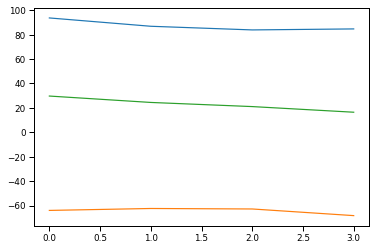

In [46]:
year=2008
plt.plot(np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_land_'+str(year)+'.npy')[0])
plt.plot(np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_land_'+str(year)+'.npy')[1])
plt.plot(np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_land_'+str(year)+'.npy')[0]+np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_land_'+str(year)+'.npy')[1])

In [94]:
f = np.zeros((2,3,17,4))
for year in range(2000,2017):
    if year==2009:
        f[:,:,9]==np.nan

    else:
        #f[year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcings_'+str(year)+'.npy')
        f[0,0,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_'+str(year)+'.npy')[0]
        f[1,0,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_'+str(year)+'.npy')[1]

        f[0,1,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_land_'+str(year)+'.npy')[0]
        f[1,1,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_land_'+str(year)+'.npy')[1]

        f[0,2,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_ocean_'+str(year)+'.npy')[0]
        f[1,2,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_ocean_'+str(year)+'.npy')[1]

        #f[:,1,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_land_'+str(year)+'.npy')
        #f[:,2,year-2000] = np.load('/net/hardin/disk1/Users/gah20/SensitivityWork/values/Forcings/forcingsLST2_ocean_'+str(year)+'.npy')


linregress_all = stats.linregress(np.arange(0,4,1),y=np.nanmedian((f[0,0,:]+f[1,0,:]),axis=0))
slope_all = linregress_all[0]
intcp_all = linregress_all[1]
r_all = linregress_all[2]**2
pval_all = linregress_all[3]
cre_ctp_s_all = (slope_all/18.75)

linregress_land = stats.linregress(np.arange(0,4,1),y=np.nanmedian((f[0,1,:]+f[1,1,:]),axis=0))
slope_land = linregress_land[0]
intcp_land = linregress_land[1]
r_land = linregress_land[2]**2
pval_land = linregress_land[3]
cre_ctp_s_land = (slope_land/18.75)

linregress_ocean = stats.linregress(np.arange(0,4,1),y=np.nanmedian((f[0,2,:]+f[1,2,:]),axis=0))
slope_ocean = linregress_ocean[0]
intcp_ocean = linregress_ocean[1]
r_ocean = linregress_ocean[2]**2
pval_ocean = linregress_ocean[3]
cre_ctp_s_ocean = (slope_ocean/18.75)


In [59]:
f[1,0,~(f[1,0,:,0]==0)]

array([[-75.63819532, -73.16850154, -71.93786908, -77.93171007],
       [-79.60892256, -74.68682454, -73.10355661, -79.53373688],
       [-81.25035117, -73.90241734, -71.58119394, -77.43846669],
       [-79.41079477, -72.62538256, -71.19111412, -77.29576479],
       [-80.2459802 , -72.80714383, -71.25895937, -77.49096085],
       [-81.43455948, -74.06633243, -71.9084216 , -77.58774503],
       [-84.2009151 , -74.85928182, -72.41115069, -78.47665638],
       [-84.33483487, -75.86010419, -73.18887917, -78.8788532 ],
       [-82.13858245, -74.49710385, -71.57701119, -77.65901756],
       [-84.92622307, -75.88958721, -73.58056178, -79.40823341],
       [-83.48425375, -75.66147945, -73.1875934 , -78.63729097],
       [-80.5649699 , -74.1258722 , -72.08049266, -78.40987574],
       [-79.50366268, -73.71643086, -71.87191812, -78.57319802],
       [-78.99450112, -73.9540492 , -71.51932123, -77.76797215],
       [-81.04950863, -75.09916326, -73.86815853, -80.41256234],
       [-79.90579902, -75

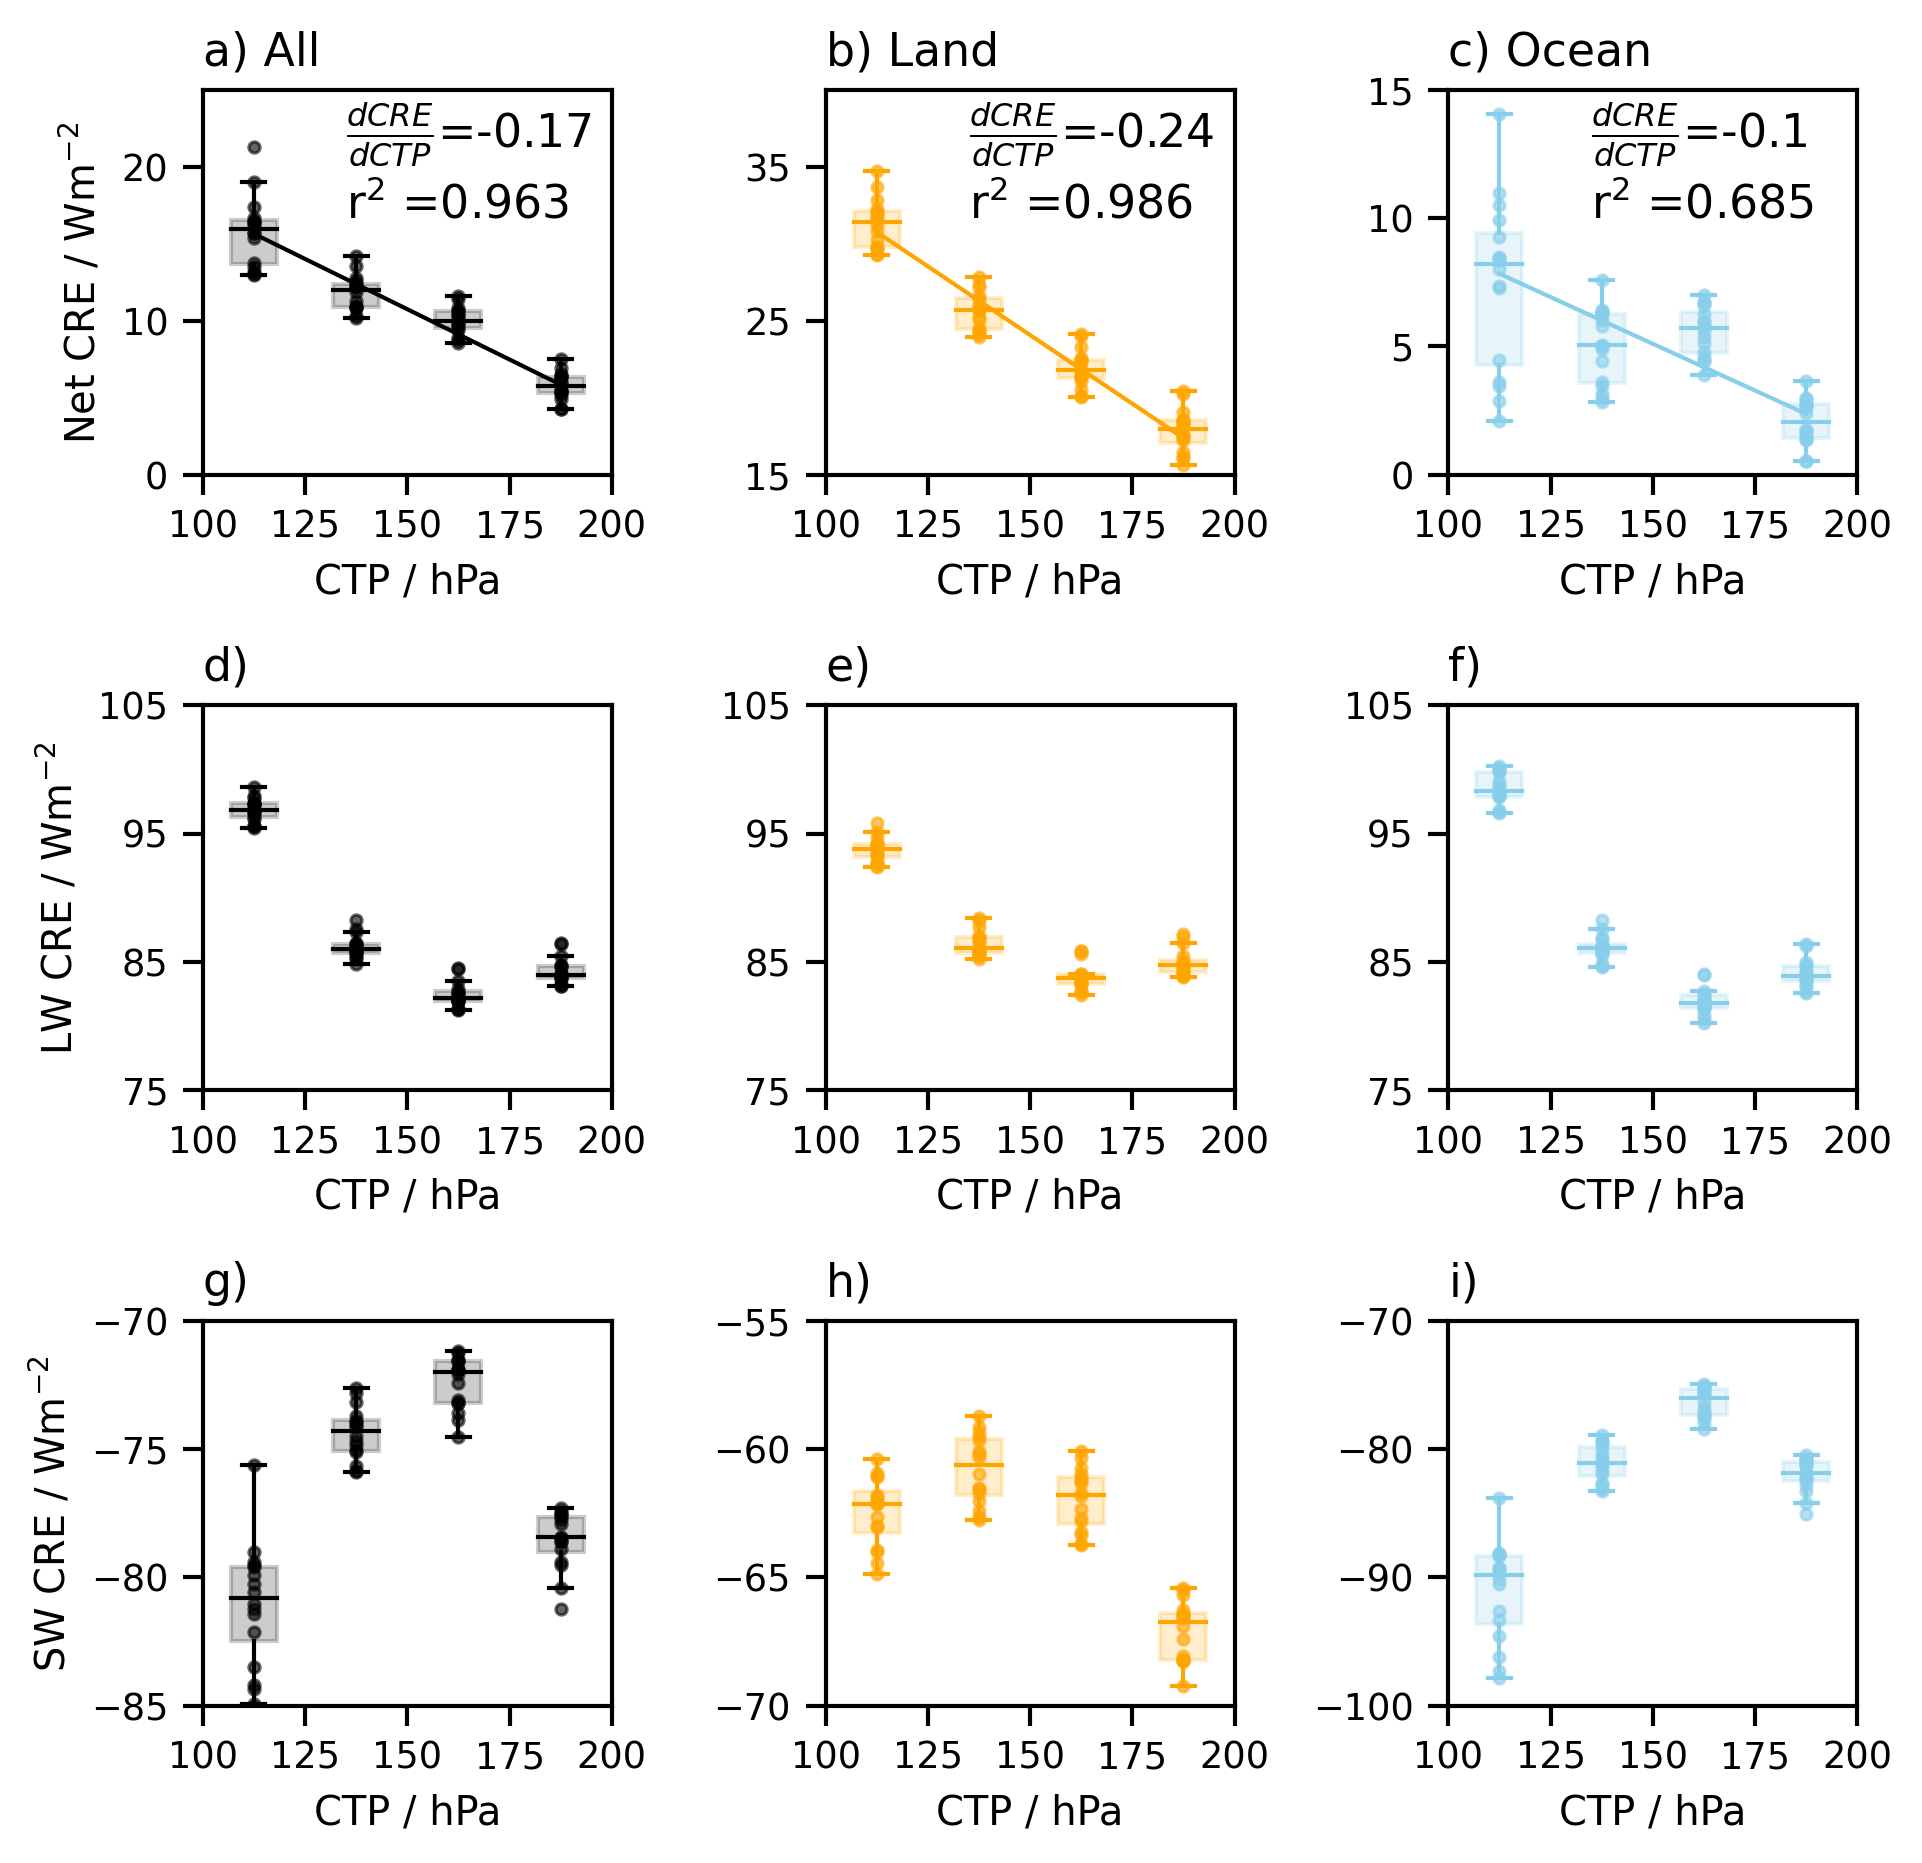

In [143]:
cm = 1/2.54 
c='k'
import seaborn as sns
fig = plt.figure(figsize=(16.5*cm,16*cm),dpi=300)
sns.set_context('paper')
gs = fig.add_gridspec(3, 3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

for i in range(0,16):
    ax0.scatter(np.arange(1,5,1),(f[0,0,~(f[0,0,:,0]==0)]+f[1,0,~(f[1,0,:,0]==0)])[i],alpha=0.6,s=7,color='k')
    ax3.scatter(np.arange(1,5,1),f[0,0,~(f[0,0,:,0]==0)][i],alpha=0.6,s=7,color='k')
    ax6.scatter(np.arange(1,5,1),f[1,0,~(f[1,0,:,0]==0)][i],alpha=0.6,s=7,color='k')

    ax1.scatter(np.arange(1,5,1),(f[0,1,~(f[0,1,:,0]==0)]+f[1,1,~(f[1,1,:,0]==0)])[i],alpha=0.6,s=7,color='orange')
    ax4.scatter(np.arange(1,5,1),f[0,1,~(f[0,1,:,0]==0)][i],alpha=0.6,s=7,color='orange')
    ax7.scatter(np.arange(1,5,1),f[1,1,~(f[1,1,:,0]==0)][i],alpha=0.6,s=7,color='orange')

    ax2.scatter(np.arange(1,5,1),(f[0,2,~(f[0,2,:,0]==0)]+f[1,2,~(f[1,2,:,0]==0)])[i],alpha=0.6,s=7,color='skyblue')
    ax5.scatter(np.arange(1,5,1),f[0,2,~(f[0,2,:,0]==0)][i],alpha=0.6,s=7,color='skyblue')
    ax8.scatter(np.arange(1,5,1),f[1,2,~(f[1,2,:,0]==0)][i],alpha=0.6,s=7,color='skyblue')

ax0.boxplot((f[0,0,~(f[0,0,:,0]==0)]+f[1,0,~(f[1,0,:,0]==0)])[:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax3.boxplot(f[0,0,~(f[0,0,:,0]==0)][:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax6.boxplot(f[1,0,~(f[1,0,:,0]==0)][:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
c='orange'
ax1.boxplot((f[0,1,~(f[0,1,:,0]==0)]+f[1,1,~(f[1,1,:,0]==0)])[:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax4.boxplot(f[0,1,~(f[0,1,:,0]==0)][:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax7.boxplot(f[1,1,~(f[1,1,:,0]==0)][:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

c='skyblue'
ax2.boxplot((f[0,2,~(f[0,2,:,0]==0)]+f[1,2,~(f[1,2,:,0]==0)])[:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax5.boxplot(f[0,2,~(f[0,2,:,0]==0)][:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

ax8.boxplot(f[1,2,~(f[1,2,:,0]==0)][:],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))


ax0.plot(np.arange(1,5,1),slope_all*np.arange(0,4,1)+intcp_all,color='k',linewidth=1)
ax1.plot(np.arange(1,5,1),slope_land*np.arange(0,4,1)+intcp_land,color='orange',linewidth=1)
ax2.plot(np.arange(1,5,1),slope_ocean*np.arange(0,4,1)+intcp_ocean,color='skyblue',linewidth=1)

ax0.set_xticks(np.arange(0.5,5.5,1))
ax0.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)
ax1.set_xticks(np.arange(0.5,5.5,1))
ax1.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)
ax2.set_xticks(np.arange(0.5,5.5,1))
ax2.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)

ax3.set_xticks(np.arange(0.5,5.5,1))
ax3.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)
ax4.set_xticks(np.arange(0.5,5.5,1))
ax4.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)
ax5.set_xticks(np.arange(0.5,5.5,1))
ax5.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)

ax6.set_xticks(np.arange(0.5,5.5,1))
ax6.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)
ax7.set_xticks(np.arange(0.5,5.5,1))
ax7.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)
ax8.set_xticks(np.arange(0.5,5.5,1))
ax8.set_xticklabels(labels=('100','125','150','175','200'),rotation=0)

ax0.set_ylabel('Net CRE / Wm$^{-2}$')
ax3.set_ylabel('LW CRE / Wm$^{-2}$')
ax6.set_ylabel('SW CRE / Wm$^{-2}$')

ax0.set_xlabel('CTP / hPa')
ax1.set_xlabel('CTP / hPa')
ax2.set_xlabel('CTP / hPa')
ax3.set_xlabel('CTP / hPa')
ax4.set_xlabel('CTP / hPa')
ax5.set_xlabel('CTP / hPa')
ax6.set_xlabel('CTP / hPa')
ax7.set_xlabel('CTP / hPa')
ax8.set_xlabel('CTP / hPa')

ax3.set_ylim(80,105)
ax4.set_ylim(80,105)
ax5.set_ylim(80,105)
ax3.set_yticks(np.arange(75,115,10))
ax4.set_yticks(np.arange(75,115,10))
ax5.set_yticks(np.arange(75,115,10))

ax6.set_ylim(-85,-70)
ax7.set_ylim(-70,-55)
ax8.set_ylim(-100,-70)

ax0.set_ylim(0,25)
ax0.set_yticks(np.arange(0,30,10))
ax1.set_ylim(15,40)
ax1.set_yticks(np.arange(15,45,10))
ax2.set_ylim(0,15)
ax2.set_yticks(np.arange(0,20,5))

#ax3.set_ylim(80,100)
#ax6.set_ylim(-90,-70)

#ax0.text(0.05,1.05,'a) All',transform=ax0.transAxes,fontsize=11)
#ax1.text(0.05,1.05,'b) Land',transform=ax1.transAxes,fontsize=11)
#ax2.text(0.05,1.05,'c) Ocean',transform=ax2.transAxes,fontsize=11)

ax0.set_title('a) All',fontsize=11,loc='left')
ax1.set_title('b) Land',fontsize=11,loc='left')
ax2.set_title('c) Ocean',fontsize=11,loc='left')
ax3.set_title('d)',fontsize=11,loc='left')
ax4.set_title('e)',fontsize=11,loc='left')
ax5.set_title('f)',fontsize=11,loc='left')
ax6.set_title('g)',fontsize=11,loc='left')
ax7.set_title('h)',fontsize=11,loc='left')
ax8.set_title('i)',fontsize=11,loc='left')


ax0.text(s=r'$\frac{dCRE}{dCTP}$=' +str(np.round(slope_all/18.75,2)),y=0.85,x=0.35,transform=ax0.transAxes,fontsize=11)
ax1.text(s=r'$\frac{dCRE}{dCTP}$=' +str(np.round(slope_land/18.75,2)),y=0.85,x=0.35,transform=ax1.transAxes,fontsize=11)
ax2.text(s=r'$\frac{dCRE}{dCTP}$=' +str(np.round(slope_ocean/18.75,2)),y=0.85,x=0.35,transform=ax2.transAxes,fontsize=11)

ax0.text(s=r'r$^2$ =' +str(np.round(r_all**2,3)),y=0.67,x=0.35,transform=ax0.transAxes,fontsize=11)
ax1.text(s=r'r$^2$ =' +str(np.round(r_land**2,3)),y=0.67,x=0.35,transform=ax1.transAxes,fontsize=11)
ax2.text(s=r'r$^2$ =' +str(np.round(r_ocean**2,3)),y=0.67,x=0.35,transform=ax2.transAxes,fontsize=11)

plt.tight_layout()
plt.savefig('/disk1/Users/gah20/SensitivityWork/PaperPlots/CRE_sens_boxplot_LWSW.pdf',dpi=300)
#plt.savefig('cre_sens_boxplot_LO.pdf',dpi=500)


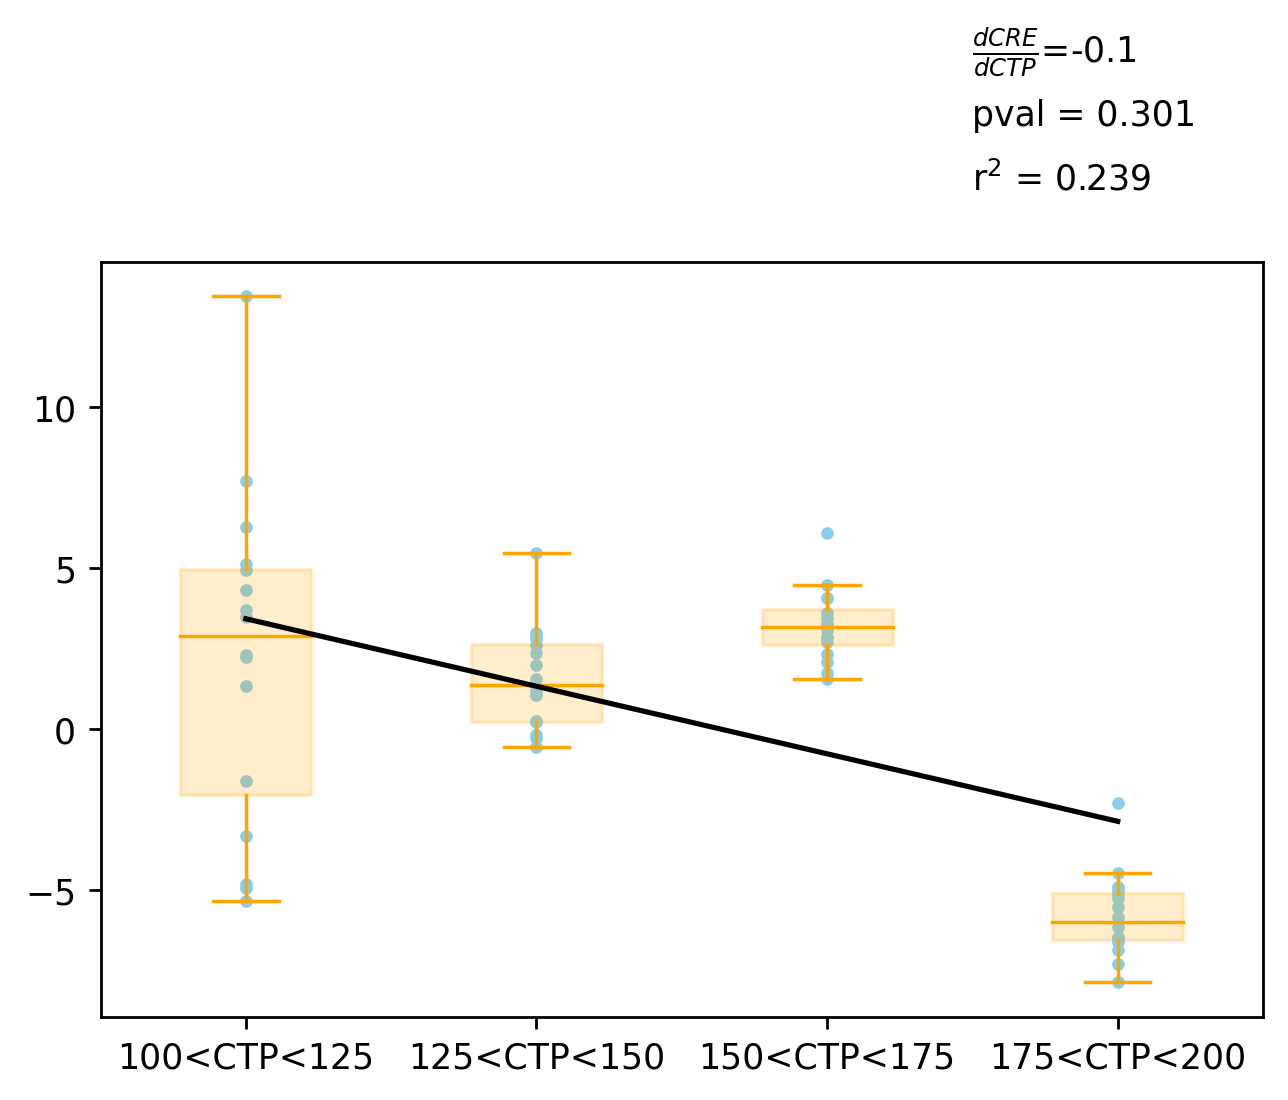

In [77]:
plt.figure(dpi=500)
for i in range(16):
    plt.scatter(np.arange(1,5,1),f[~(f[:,2]==0)][i],alpha=1,s=7,color='skyblue')


plt.boxplot(f[~(f[:,2]==0)],patch_artist=True,sym="",zorder=1,

            boxprops=dict(facecolor=c, color=c,alpha=0.2),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
plt.plot(np.arange(1,5,1),slope*np.arange(0,4,1) + intcp,color='k')

plt.text(s=r'$\frac{dCRE}{dCTP}$=' +str(np.round(slope/18.75,1)),y=20.75,x=3.5)
plt.text(s='pval = '+str(np.round(pval,3)),y=18.75,x=3.5)
plt.text(s='r$^2$ = '+str(np.round(r**2,3)),y=16.75,x=3.5)
plt.xticks(np.arange(1,5,1),labels=('100<CTP<125','125<CTP<150','150<CTP<175','175<CTP<200'))

plt.plot()
#plt.savefig('SensitivityWork/sens_boxplot.pdf',dpi=500)
plt.show()

In [ ]:
plt.figure(figsize=(6,3),dpi=300)
plt.plot(slope*np.arange(0,4,1) + intcp)
plt.scatter(np.arange(0,4,1),(LWDETsum_1+SWDETsum_1,LWDETsum_2+SWDETsum_2,LWDETsum_3+SWDETsum_3,LWDETsum_4+SWDETsum_4),label='CTP',s=15)
plt.ylabel('CRE / Wm$^{-2}$')
plt.xlabel('CTP / hPa')
plt.text(s=r'$\frac{dCRE}{dCTP}$=' +str(np.round(slope/18.75,1)),y=10.75,x=2.5)
plt.text(s='pval = '+str(np.round(pval,3)),y=12.75,x=2.5)
plt.text(s='r$^2$ = '+str(np.round(r**2,3)),y=11.75,x=2.5)
plt.xticks(np.arange(0,4,1),labels=('100<CTP<125','125<CTP<150','150<CTP<175','175<CTP<200'))
plt.savefig('SensitivityWork/dctp_dcre.png',dpi=500)


In [ ]:
plt.imshow((H_norm_lw_1_det.T),vmax=0.002,aspect='auto')
plt.xlim(0,120)

In [ ]:
plt.figure(dpi=500)
plt.xlim(0,120)

plt.axhline(y=0,color='black',linewidth=0.5)

#plt.plot(weightedlw+weightedsw)
plt.plot(LW_AVERAGE_l,label='Weak LW',color='red',linestyle='dashed')
plt.plot(LW_AVERAGE_o,label='Strong LW',color='red')

plt.plot(SW_AVERAGE_l,label='Weak SW',color='blue',linestyle='dashed')
plt.plot(SW_AVERAGE_o,label='Strong SW',color='blue')

plt.plot(LW_AVERAGE_l + SW_AVERAGE_l,label='Weak Net',color='black',linestyle='dashed')
plt.plot(LW_AVERAGE_o + SW_AVERAGE_o,label='Strong Net',color='black',linestyle='solid')
plt.ylabel('High Cloud CRE / Wm$^{-2}$')
plt.xlabel('Time Since Convection / hours')


plt.legend(ncol=3)
plt.savefig('ConvStrength.png',dpi=500)

In [ ]:
tsc[0::3]

In [ ]:
import csat2
lstline = np.zeros((33,24))
lstline_strong = np.zeros((33,24))
lstline_weak = np.zeros((33,24))

lstdcc = np.zeros((33,24,60,360))
lstdcc_strong = np.zeros((33,24,60,360))
lstdcc_weak = np.zeros((33,24,60,360))

COUNT = 0
for year in range(1985,2017,1):
    dccdata = xr.open_mfdataset('/disk1/Users/gah20/DCC/'+str(year)+'/*.nc',combine='nested',concat_dim='time')['DCC'][:,60:120]
    dcczero = dccdata/dccdata
    dcc_amt = np.where(np.isnan(dcczero),0,1)[0:2915]

    convstrength = xr.open_mfdataset('/disk1/Users/gah20/TSC_FULL/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvPc'][0::3,2:62]
    mask_weak = np.where(convstrength>50,1,0)[0:2915]
    mask_strong = np.where(convstrength<-50,1,0)[0:2915]

    dcc_amt_strong = dcc_amt*mask_strong
    dcc_amt_weak = dcc_amt*mask_weak

    dcc_yearly = np.zeros((9, 60, 360))
    dcc_yearly_strong = np.zeros((9, 60, 360))
    dcc_yearly_weak = np.zeros((9, 60, 360))
    
    for i in range(0,9,1):
        if i==9:
            dcc_yearly[i] = np.nansum(dcc_amt[0::8][:],axis=0)
            dcc_yearly_strong[i] = np.nansum(dcc_amt_strong[0::8][:],axis=0)
            dcc_yearly_weak[i] = np.nansum(dcc_amt_weak[0::8][:],axis=0)

        dcc_yearly[i] = np.nansum(dcc_amt[i::8][:],axis=0)
        dcc_yearly_strong[i] = np.nansum(dcc_amt_strong[i::8][:],axis=0)
        dcc_yearly_weak[i] = np.nansum(dcc_amt_weak[i::8][:],axis=0)

    dcc_transpose = np.transpose(np.asarray(dcc_yearly), (1, 2, 0))
    dcc_transpose_strong = np.transpose(np.asarray(dcc_yearly_strong), (1,2,0))
    dcc_transpose_weak = np.transpose(np.asarray(dcc_yearly_weak), (1,2,0))

    lstdcczero = np.zeros((24,60,360))
    lstdcczero_strong = np.zeros((24,60,360))
    lstdcczero_weak = np.zeros((24,60,360))
    for i in range(0,24,1):
        lstdcczero[i] = csat2.misc.time.toLocalSolarTime(i,np.arange(0,25,3),np.arange(0,360,1),np.asarray(dcc_transpose[:]),interpolation='nearest')
        lstdcczero_strong[i] = csat2.misc.time.toLocalSolarTime(i,np.arange(0,25,3),np.arange(0,360,1),np.asarray(dcc_transpose_strong[:]),interpolation='nearest')
        lstdcczero_weak[i] = csat2.misc.time.toLocalSolarTime(i,np.arange(0,25,3),np.arange(0,360,1,),np.asarray(dcc_transpose_weak[:]),interpolation='nearest')
    
    lstdcc[COUNT] = lstdcczero
    lstdcc_strong[COUNT] = lstdcczero_strong
    lstdcc_weak[COUNT] = lstdcczero_weak

    lstline[COUNT] = np.nansum(lstdcczero,axis=(1,2))
    lstline_strong[COUNT] = np.nansum(lstdcczero_strong,axis=(1,2))
    lstline_weak[COUNT] = np.nansum(lstdcczero_weak,axis=(1,2))
    COUNT+=1
    print(year) 

In [ ]:
cm = 1/2.54 
import seaborn as sns
fig = plt.figure(figsize=(16.5*cm,7*cm),dpi=300)
sns.set_context('paper')
gs = fig.add_gridspec(1, 3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

#for i in range(32):
    #ax0.plot(lstline[i]/np.nanmax(lstline),color='k',alpha=0.2)
    #ax1.plot(lstline_strong[i]/np.nanmax(lstline_strong),color='k',alpha=0.2)
    #ax2.plot(lstline_weak[i]/np.nanmax(lstline_weak),color='k',alpha=0.2)

ax0.plot(np.nanmean(lstline,axis=0)/np.nanmax(lstline),color='k',linewidth=2,alpha=1,label='Mean')
ax1.plot(np.nanmean(lstline_strong,axis=0)/np.nanmax(lstline_strong),color='orange',linewidth=2,alpha=1)
ax2.plot(np.nanmean(lstline_weak,axis=0)/np.nanmax(lstline_weak),color='skyblue',linewidth=2,alpha=1)

ax0.fill_between(np.arange(0,24,1),np.nanmean(lstline,axis=0)/np.nanmax(lstline)-np.nanstd(lstline,axis=0)/np.nanmax(lstline),np.nanmean(lstline,axis=0)/np.nanmax(lstline)+np.nanstd(lstline,axis=0)/np.nanmax(lstline),color='k',alpha=0.2)
ax1.fill_between(np.arange(0,24,1),np.nanmean(lstline_strong,axis=0)/np.nanmax(lstline_strong)-np.nanstd(lstline_strong,axis=0)/np.nanmax(lstline_strong),np.nanmean(lstline_strong,axis=0)/np.nanmax(lstline_strong)+np.nanstd(lstline_strong,axis=0)/np.nanmax(lstline_strong),color='orange',alpha=0.2)
ax2.fill_between(np.arange(0,24,1),np.nanmean(lstline_weak,axis=0)/np.nanmax(lstline_weak)-np.nanstd(lstline_weak,axis=0)/np.nanmax(lstline_weak),np.nanmean(lstline_weak,axis=0)/np.nanmax(lstline_weak)+np.nanstd(lstline_weak,axis=0)/np.nanmax(lstline_weak),color='skyblue',alpha=0.2)
    #ax0.plot(np.nansum(lstline[(year-1984)*12:((year-1984)+1)*12],axis=0),color='k',alpha=0.1)
    #ax1.plot(np.nansum(lstline_land[(year-1984)*12:((year-1984)+1)*12],axis=0),color='k',alpha=0.1)
    #ax2.plot(np.nansum(lstline_ocean[(year-1984)*12:((year-1984)+1)*12],axis=0),color='k',alpha=0.1)

    #plt.plot(lstline_ocean[i]/np.nanmax(lstline_ocean[i]))
    #plt.plot(lstline_ocean[i])
ax0.legend(loc='lower left')
#ax2.legend(loc='lower left')
#ax3.legend(loc='lower left')

ax0.set_xlabel('Local Solar Time / hours')
ax1.set_xlabel('Local Solar Time  / hours')
ax2.set_xlabel('Local Solar Time  / hours')

ax0.set_ylim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax2.set_ylim(0.0,1.2)

ax0.set_xlim(0,23)
ax1.set_xlim(0,23)
ax2.set_xlim(0,23)

ax1.set_yticklabels([])
ax2.set_yticklabels([])

ax0.set_title('Global')
ax1.set_title('Strong')
ax2.set_title('Weak')

ax0.text(0,1.05,'(a)',transform=ax0.transAxes)
ax1.text(0,1.05,'(b)',transform=ax1.transAxes)
ax2.text(0,1.05,'(c)',transform=ax2.transAxes)

plt.xlabel('Local Solar Time / hours')
ax0.set_ylabel('Normalised DCC Count')
plt.tight_layout()
plt.savefig('ClimatologyWork/ClimatologyPlots/DCC_weakstrong_LST_timeseries_std.png',dpi=500)
plt.show()


In [ ]:
plt.hist(np.asarray(isccp).flatten(),bins=100)

In [ ]:
isccp

In [ ]:
ctp_land=[]
ctp_ocean=[]
for year in range(2004,2005,1):
    isccp = xr.open_mfdataset('/net/hardin/disk1/Data/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/'+str(year)+'*.nc',combine='nested',concat_dim='time')['tc'][:,60:120]
    dcc = xr.open_mfdataset('/net/hardin/disk1/Users/gah20/DCC/'+str(year)+'/*.nc',combine='nested',concat_dim='time')['DCC'][:,60:120]
    ctp = np.where(isccp<0,np.nan,isccp)
    dcc_amt = dcc/dcc


    tsc_LO = xr.open_mfdataset('/net/hardin/disk1/Users/gah20/TSC_FULL/'+str(year)+'/TSC_*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62]
    maskl = np.where(tsc_LO>0,1,0)[0::3]
    masko = np.where(tsc_LO<0,1,0)[0::3]

    dcc_amt_land = dcc_amt*maskl
    dcc_amt_ocean = dcc_amt*masko

    ctp_land = ((np.where(dcc_amt_land==1,ctp,np.nan))).flatten()
    ctp_ocean = ((np.where(dcc_amt_ocean==1,ctp,np.nan))).flatten()
    print(year)

In [ ]:
fig,ax1=plt.subplots()
plt.hist(np.asarray(ctp_land).flatten(),bins=np.arange(180,250,5),alpha=0.7,label='land',color='orange',density=True)
plt.hist(np.asarray(ctp_ocean).flatten(),bins=np.arange(180,250,5),alpha=0.7,label='ocean',color='skyblue',density=True)
#plt.xlim(105,220)
plt.legend()
